In [1]:
!source /opt/intel/openvino/bin/setupvars.sh

[setupvars.sh] OpenVINO environment initialized


# 导入工具库

In [2]:
import openvino
import argparse
import cv2
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# 初始化Inference Engine

In [3]:
'''
Contains code for working with the Inference Engine.
You'll learn how to implement this code and more in
the related lesson on the topic.
'''

import os
import sys
import logging as log
from openvino.inference_engine import IENetwork, IECore

class Network:
    '''
    Load and store information for working with the Inference Engine,
    and any loaded models.
    '''

    def __init__(self):
        self.plugin = None
        self.input_blob = None
        self.exec_network = None


    def load_model(self, model, device="CPU", cpu_extension=None):
        '''
        Load the model given IR files.
        Defaults to CPU as device for use in the workspace.
        Synchronous requests made within.
        '''
        model_xml = model
        model_bin = os.path.splitext(model_xml)[0] + ".bin"

        # Initialize the plugin
        self.plugin = IECore()

        # Add a CPU extension, if applicable
        if cpu_extension and "CPU" in device:
            self.plugin.add_extension(cpu_extension, device)

        # Read the IR as a IENetwork
        network = self.plugin.read_network(model=model_xml, weights=model_bin)

        # Load the IENetwork into the plugin
        self.exec_network = self.plugin.load_network(network, device)

        # Get the input layer
        self.input_blob = next(iter(network.inputs))

        # Return the input shape (to determine preprocessing)
        return network.inputs[self.input_blob].shape


    def sync_inference(self, image):
        '''
        Makes a synchronous inference request, given an input image.
        '''
        self.exec_network.infer({self.input_blob: image})
        return


    def extract_output(self):
        '''
        Returns a list of the results for the output layer of the network.
        '''
        return self.exec_network.requests[0].outputs


In [4]:
# 实例化Network
inference_network = Network()

In [5]:
n, c, h, w = inference_network.load_model('models/human-pose-estimation-0001.xml', 'CPU', None)

In [6]:
n

1

In [7]:
c

3

In [8]:
h

256

In [9]:
w

456

# 导入图片

In [241]:
image_path = 'images/sitting-on-car.jpg'

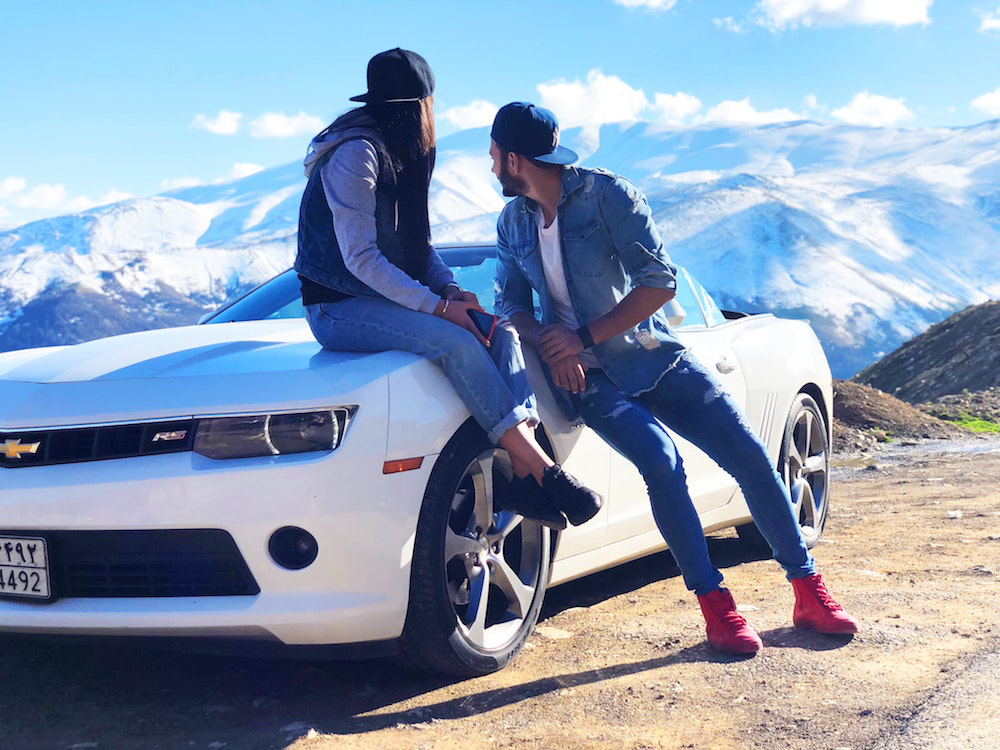

In [242]:
from PIL import Image
im = Image.open(image_path)
im

In [243]:
# Read the input image
image = cv2.imread(image_path)

In [244]:
image.shape

(750, 1000, 3)

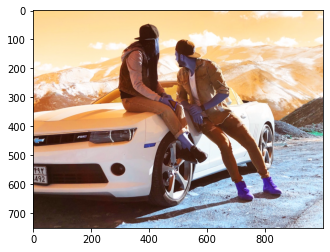

In [245]:
plt.imshow(image)
plt.show()

# 预处理

In [246]:
def preprocessing(input_image, height, width):
    '''
    Given an input image, height and width:
    - Resize to width and height
    - Transpose the final "channel" dimension to be first
    - Reshape the image to add a "batch" of 1 at the start 
    '''
    image = np.copy(input_image)
    image = cv2.resize(image, (width, height))
    image = image.transpose((2,0,1))
    image = image.reshape(1, 3, height, width)

    return image

In [247]:
preprocessed_image = preprocessing(image, h, w)

In [248]:
preprocessed_image.shape

(1, 3, 256, 456)

# 可视化预处理之后的图像

In [249]:
resized_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

In [250]:
resized_image = cv2.resize(resized_image, (w, h))

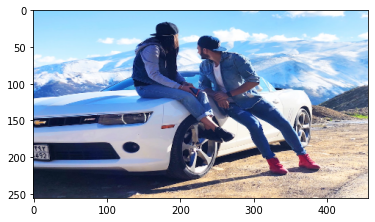

In [251]:
plt.imshow(resized_image)

# 在Inference Engine中进行推断

In [252]:
# Perform synchronous inference on the image
inference_network.sync_inference(preprocessed_image)

In [253]:
# Obtain the output of the inference request
output = inference_network.extract_output()

In [254]:
output

{'Mconv7_stage2_L1': array([[[[ 9.91225243e-05,  9.91225243e-05,  9.91225243e-05, ...,
            9.91225243e-05,  9.91225243e-05,  9.91225243e-05],
          [ 9.91225243e-05,  9.91225243e-05,  9.91225243e-05, ...,
            9.91225243e-05,  9.91225243e-05,  9.91225243e-05],
          [ 9.91225243e-05,  9.91225243e-05,  9.91225243e-05, ...,
            9.91225243e-05,  9.91225243e-05,  9.91225243e-05],
          ...,
          [ 9.91225243e-05,  9.91225243e-05,  9.91225243e-05, ...,
            9.91225243e-05,  9.91225243e-05,  9.91225243e-05],
          [ 9.91225243e-05,  3.55298689e-05,  2.92487493e-05, ...,
            9.91225243e-05,  1.17282507e-04,  9.91225243e-05],
          [ 9.91225243e-05,  9.91225243e-05,  9.91225243e-05, ...,
            9.91225243e-05,  9.91225243e-05,  9.91225243e-05]],
 
         [[ 4.51803207e-04,  4.51803207e-04,  4.51803207e-04, ...,
            4.51803207e-04,  4.51803207e-04,  4.51803207e-04],
          [ 4.51803207e-04,  4.51803207e-04,  4.5180

In [255]:
output.keys()

dict_keys(['Mconv7_stage2_L1', 'Mconv7_stage2_L2'])

In [256]:
output['Mconv7_stage2_L1'].shape

(1, 38, 32, 57)

In [257]:
output['Mconv7_stage2_L2'].shape

(1, 19, 32, 57)

In [258]:
input_shape = image.shape
heatmaps = output['Mconv7_stage2_L2']
out_heatmap = np.zeros([heatmaps.shape[1], input_shape[0], input_shape[1]])
for j in range(len(heatmaps[0])):
    out_heatmap[j] = cv2.resize(heatmaps[0][j], input_shape[0:2][::-1])

In [259]:
out_heatmap.shape

(19, 750, 1000)

# 结果可视化

In [260]:
output = out_heatmap

In [261]:
# Remove final part of output not used for heatmaps
output = output[:-1]

In [262]:
# 18个关键点的热力图
output.shape

(18, 750, 1000)

In [263]:
len(output)

18

In [264]:
# Get only pose detections above 0.5 confidence, set to 255
for c in range(len(output)):
    output[c] = np.where(output[c]>0.5, 255, 0)

In [265]:
output[1].shape

(750, 1000)

In [266]:
i = 1

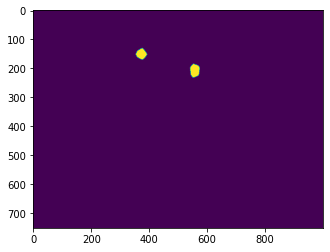

In [267]:
# 不停运行本代码块
plt.imshow(output[i])
i += 1

In [268]:
# Sum along the "class" axis
# 将所有18个关键点的热力图放在一个图里
output = np.sum(output, axis=0)

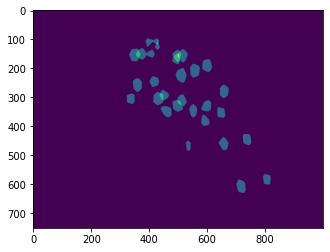

In [269]:
plt.imshow(output)

In [270]:
# 获取mask，将output设置为绿色通道
empty = np.zeros(output.shape)
mask = np.dstack((empty, output, empty))

In [271]:
mask.max()

765.0

In [272]:
# Combine with original image
image = image + mask

# 存储可视化结果图像

In [274]:
# Save down the resulting image
output_path = "outputs/{}-output.png".format('zihao-body-detection')
cv2.imwrite(output_path, image)

True

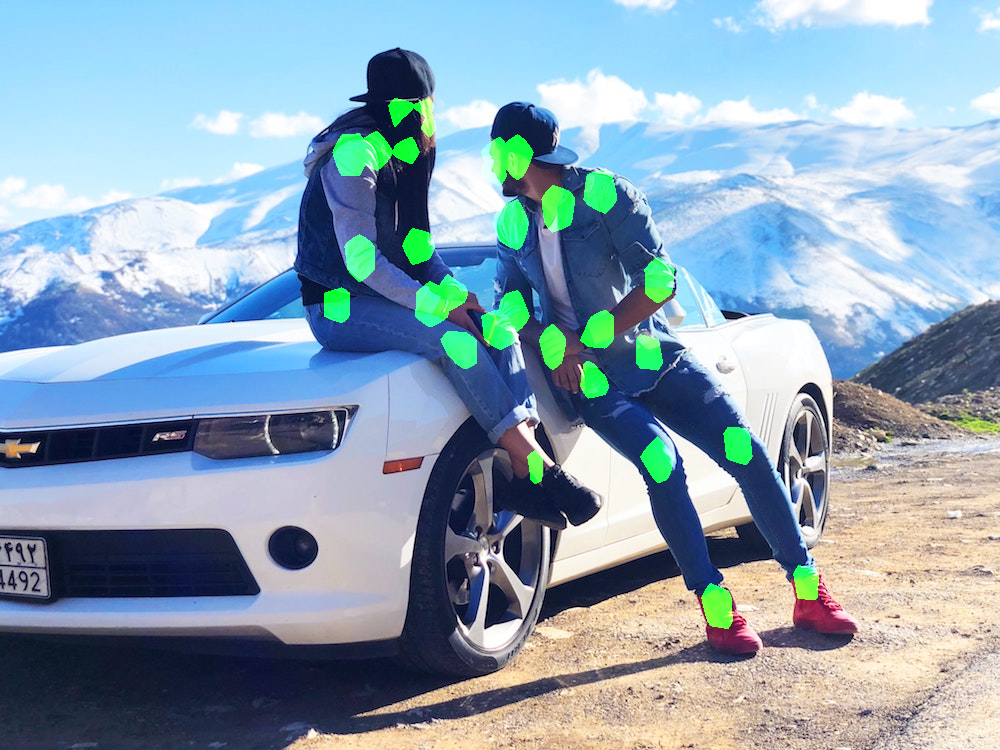

In [275]:
from PIL import Image
im = Image.open(output_path)
im

In [369]:
# Save down the resulting image
output_path = "outputs/{}-output.png".format('zihao-body-detection')
cv2.imwrite(output_path, frame)

True